# Introduction to Tensorflow Hub for Object Detection (with SSD+MobileNetV2)

The purpose of this kernel is to walk you through the process of downloading a pre-trained TF model from the Tensorflow Hub, building a Tensorflow graph and performing off-the-shelf predictions. This kernel is a fork of the excellent [baseline kernel by Vikram](https://www.kaggle.com/vikramtiwari/baseline-predictions-using-inception-resnet-v2), but differs on those points:
1. We will be using MobileNet v2 instead of Inception-ResNet. This means that the inference will be faster*, but the accuracy ends up worse.
2. This will focus on understanding how Tensorflow works, rather than providing a boilerplate. For a simple solution, please check out [this tutorial](https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/object_detection.ipynb), which is what Vikram's kernel was inspired from.

\* Each image takes roughly 0.2s to process, whereas Inception-ResNet takes around 1.2s.

## Changelog

* V6: As pointed out by [Nicolas in his kernel](https://www.kaggle.com/nhlr21/tf-hub-bounding-boxes-coordinates-corrected/notebook) and in this [discussion thread](https://www.kaggle.com/c/open-images-2019-object-detection/discussion/98205), the coordinates are inverted between the Kaggle competition and the original TF Hub graph. This version corrects this problem. Please go give them an upvote; this is a really good catch from them!

## References

* Vikram's Original Kernel: https://www.kaggle.com/vikramtiwari/baseline-predictions-using-inception-resnet-v2
* TFHub Demo: https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/object_detection.ipynb
* TFHub Model link: https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1
* Discussion on inveted BBox: https://www.kaggle.com/c/open-images-2019-object-detection/discussion/98205
* Corrected BBox: https://www.kaggle.com/nhlr21/tf-hub-bounding-boxes-coordinates-corrected/notebook

In [1]:
import os
from pprint import pprint
from six import BytesIO

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from PIL import Image, ImageColor, ImageDraw, ImageFont, ImageOps
from tqdm import tqdm

# Utility Functions

In this section, we define a few functions that will be used for processing images and formatting the output prediction. You can safely skip this section and use the following functions as is:
* `format_prediction_string(image_id, result)`: `image_id` is the ID of the test image you are trying to label. `result` is the dictionary created from running a `tf.Session`. The output is a formatted output row (i.e. `{Label Confidence XMin YMin XMax YMax},{...}`), so we need to modify the order from Tensorflow, which is by default `YMin XMin YMax XMax` (Thanks to [Nicolas for discovering this](https://www.kaggle.com/nhlr21/tf-hub-bounding-boxes-coordinates-corrected/notebook)).
* `draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1)`: `image` is a numpy array representing an image, `boxes`, `class_names`, and `scores` are directly retrieved from the model predictions.
* `display_image(image)`: Display a numpy array representing an `image`.

In [2]:
def format_prediction_string(image_id, result):
    prediction_strings = []
    
    for i in range(len(result['detection_scores'])):
        class_name = result['detection_class_names'][i].decode("utf-8")
        YMin,XMin,YMax,XMax = result['detection_boxes'][i]
        score = result['detection_scores'][i]
        
        prediction_strings.append(
            f"{class_name} {score} {XMin} {YMin} {XMax} {YMax}"
        )
        
    prediction_string = " ".join(prediction_strings)

    return {
        "ImageID": image_id,
        "PredictionString": prediction_string
    }

In [3]:
def display_image(image):
    fig = plt.figure(figsize=(20, 15))
    plt.grid(False)
    plt.axis('off')
    plt.imshow(image)

Unhide the cell below to see how the intermediate function `draw_bounding_box_on_image` is constructed.

In [4]:
def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
    """Adds a bounding box to an image."""
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                  ymin * im_height, ymax * im_height)
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
               (left, top)],
              width=thickness,
              fill=color)

    # If the total height of the display strings added to the top of the bounding
    # box exceeds the top of the image, stack the strings below the bounding box
    # instead of above.
    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
    # Each display_str has a top and bottom margin of 0.05x.
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = bottom + total_display_str_height
    # Reverse list and print from bottom to top.
    for display_str in display_str_list[::-1]:
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                        (left + text_width, text_bottom)],
                       fill=color)
        draw.text((left + margin, text_bottom - text_height - margin),
                  display_str,
                  fill="black",
                  font=font)
        text_bottom -= text_height - 2 * margin

In [5]:
def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
    """Overlay labeled boxes on an image with formatted scores and label names."""
    colors = list(ImageColor.colormap.values())

    try:
        font = ImageFont.truetype(
            "/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
            25)
    except IOError:
        print("Font not found, using default font.")
        font = ImageFont.load_default()

    for i in range(min(boxes.shape[0], max_boxes)):
        if scores[i] >= min_score:
            ymin, xmin, ymax, xmax = tuple(boxes[i].tolist())
            display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                           int(100 * scores[i]))
            color = colors[hash(class_names[i]) % len(colors)]
            image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
            draw_bounding_box_on_image(
                image_pil,
                ymin,
                xmin,
                ymax,
                xmax,
                color,
                font,
                display_str_list=[display_str])
            np.copyto(image, np.array(image_pil))
    return image

# Understanding the model

We will be using a Single Shot MultiBox Detector (SSD) model with a MobileNet v2 as the backbone (SSD+MobileNetV2). If you are not familiar with the literature, check out [this article about SSD](https://towardsdatascience.com/review-ssd-single-shot-detector-object-detection-851a94607d11), and [this post explaining what's new with MobileNet v2](https://towardsdatascience.com/mobilenetv2-inverted-residuals-and-linear-bottlenecks-8a4362f4ffd5). On a high level, you can think of MobileNet as a lightweight CNN that extract features from the image, and SSD as a method to efficiently scale a set of default bounding boxes around the targets.

The model is trained on [Open Images V4](https://ai.googleblog.com/2018/04/announcing-open-images-v4-and-eccv-2018.html), which is the dataset used for last year's competition. Fortunately, the labels are still the same, so the outputs of the model can be directly submitted to this competition. Here's what the author says about the dataset:

> Today, we are happy to announce Open Images V4, containing 15.4M bounding-boxes for 600 categories on 1.9M images, making it the largest existing dataset with object location annotations. The boxes have been largely manually drawn by professional annotators to ensure accuracy and consistency. The images are very diverse and often contain complex scenes with several objects (8 per image on average; visualizer). 

For our implementation, it is important to note those following points:
* This model does NOT support fine-tuning.
* The model does NOT support batching, so the input has to be **ONE** image of shape `(1, height, width, 3)`.
* It is recommended to run this module on GPU to get acceptable inference times.
* The model is loaded directly from Tensorflow Hub, so this code might not work offline.

## Running the model on a Sample Image

Let's start by running the model on a single image. We will go through each step of the process afterwards.

In [6]:
sample_image_path = "../input/test/6beb79b52308112d.jpg"

with tf.Graph().as_default():
    # Create our inference graph
    image_string_placeholder = tf.placeholder(tf.string)
    decoded_image = tf.image.decode_jpeg(image_string_placeholder)
    decoded_image_float = tf.image.convert_image_dtype(
        image=decoded_image, dtype=tf.float32
    )
    # Expanding image from (height, width, 3) to (1, height, width, 3)
    image_tensor = tf.expand_dims(decoded_image_float, 0)

    # Load the model from tfhub.dev, and create a detector_output tensor
    model_url = "https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1"
    detector = hub.Module(model_url)
    detector_output = detector(image_tensor, as_dict=True)
    
    # Initialize the Session
    init_ops = [tf.global_variables_initializer(), tf.tables_initializer()]
    sess = tf.Session()
    sess.run(init_ops)

    # Load our sample image into a binary string
    with tf.gfile.Open(sample_image_path, "rb") as binfile:
        image_string = binfile.read()

    # Run the graph we just created
    result_out, image_out = sess.run(
        [detector_output, decoded_image],
        feed_dict={image_string_placeholder: image_string}
    )

Let's see what it looks like:

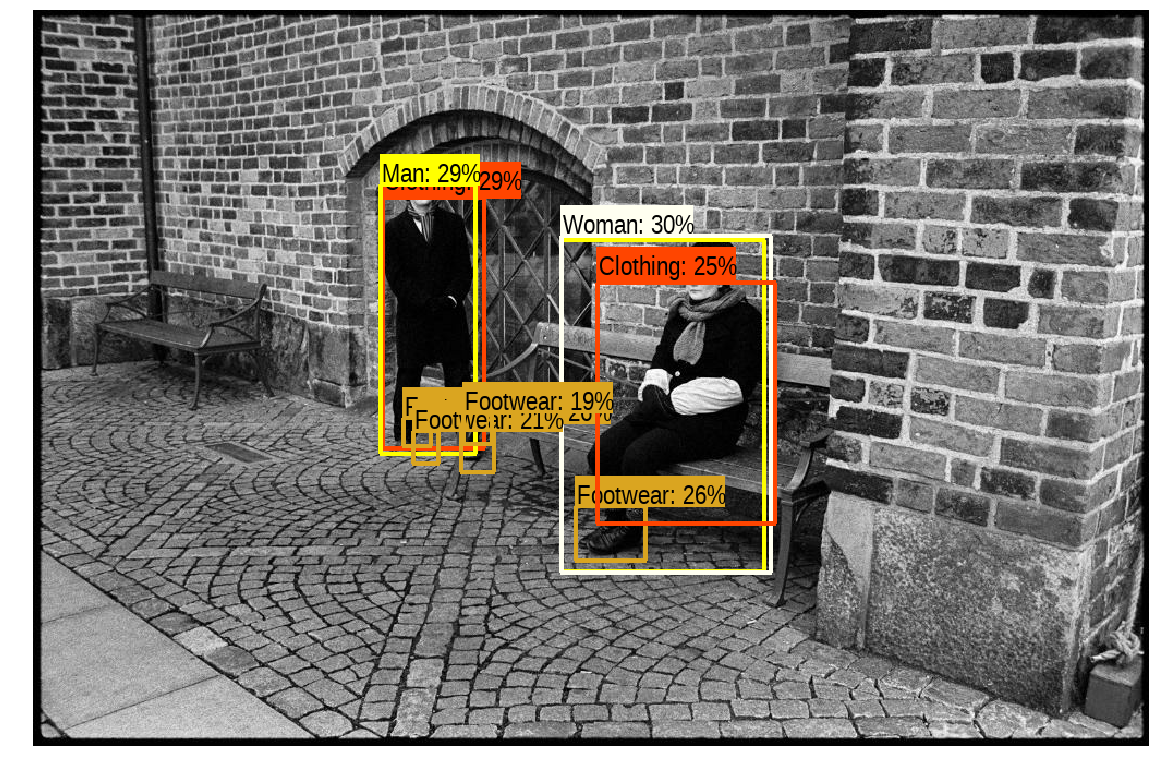

In [7]:
image_with_boxes = draw_boxes(
    np.array(image_out), result_out["detection_boxes"],
    result_out["detection_class_entities"], result_out["detection_scores"]
)
display_image(image_with_boxes)

## Step 1: Building a TF Graph

Let's take a look at at how we are building the graph:

```python
image_string_placeholder = tf.placeholder(tf.string)
decoded_image = tf.image.decode_jpeg(image_string_placeholder)
decoded_image_float = tf.image.convert_image_dtype(
    image=decoded_image, dtype=tf.float32
)
image_tensor = tf.expand_dims(decoded_image_float, 0)
```

For those unfamiliar with the the dataflow paradigm, check out this [official guide](https://www.tensorflow.org/guide/graphs). Basically, whenever you use Tensorflow, you need to build and run a graph using the building blocks (i.e. the nodes of the graph) provided by the API. In our case, our model simply consists of the following blocks:

In [8]:
print(image_string_placeholder)
print(decoded_image)
print(decoded_image_float)
print(image_tensor)

Tensor("Placeholder:0", dtype=string)
Tensor("DecodeJpeg:0", shape=(?, ?, ?), dtype=uint8)
Tensor("convert_image:0", shape=(?, ?, ?), dtype=float32)
Tensor("ExpandDims:0", shape=(1, ?, ?, ?), dtype=float32)


Each of those `tf.Tensor`s are passed to the next one, creating a [directed acyclic graph (DAG)](https://en.wikipedia.org/wiki/Directed_acyclic_graph), where the "entry point" is the variable `image_string_placeholder`.

Note that afterwards, we are feeding `image_tensor` to `detector`:
```python
model_url = "https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1"
detector = hub.Module(model_url)
detector_output = detector(image_tensor, as_dict=True)
```

In this case, `detector_output` is not a `tf.Tensor`, but a dictionary of `tf.Tensor`s:

In [9]:
pprint(detector_output)

{'detection_boxes': <tf.Tensor 'module_apply_default/hub_input/strided_slice:0' shape=(?, 4) dtype=float32>,
 'detection_class_entities': <tf.Tensor 'module_apply_default/hub_input/index_to_string_Lookup:0' shape=(?, 1) dtype=string>,
 'detection_class_labels': <tf.Tensor 'module_apply_default/hub_input/strided_slice_2:0' shape=(?, 1) dtype=int64>,
 'detection_class_names': <tf.Tensor 'module_apply_default/hub_input/index_to_string_1_Lookup:0' shape=(?, 1) dtype=string>,
 'detection_scores': <tf.Tensor 'module_apply_default/hub_input/strided_slice_1:0' shape=(?, 1) dtype=float32>}


However, this is not an issue since it will be accepted by `tf.Session`.

At this point, all we have is the "blueprint" of our model, but it has not been "produced" yet; that part is covered in Step 2 and 3.

## Step 2: Initializing the Session

*If you are familiar with context managers and tf.Graph/tf.Session, feel free to skip this part.*

If you look at any piece of Tensorflow code, you will always see something along the lines of:

```python
with tf.Graph().as_default():
    with tf.Session() as sess:
        ...
        sess.run(...)
        ...
```

But what does the `with` keyword truly do? It lets you use what is called a *context manager*. You can often see it being used for opening documents, e.g.

```python
with open('data.txt') as f:
    print(f.read())
```

Basically, you can use a variable (in this case, `f`, which stands for file) in a constrained scope, as well as perform actions before and after the `with` code block is executed. For example, the built-in function `open()` will automatically perform a `f.close()` after you are done using it. [This tutorial](https://jeffknupp.com/blog/2016/03/07/python-with-context-managers/) goes more in-depth about how this works, and show how to build your own context manager.

So how does `tf.Session()` work then? According to the [official docs](https://www.tensorflow.org/api_docs/python/tf/Session), the following two examples are equivalent:

```python
# Using the `close()` method.
sess = tf.Session()
sess.run(...)
sess.close()

# Using the context manager.
with tf.Session() as sess:
    sess.run(...)
```

This means you can either create a context in which `sess` is active, or simply initialize `sess` and close it when you are done with all your Tensorflow computation. In our code, we use the second method:

```python
init_ops = [tf.global_variables_initializer(), tf.tables_initializer()]
sess = tf.Session()
sess.run(init_ops)
```

If you are confused about why we have those `init_ops` and need to run them before using `sess` for inference, check out this [StackOverflow thread](https://stackoverflow.com/questions/44433438/understanding-tf-global-variables-initializer). The [official docs section on variable initialization](https://www.tensorflow.org/guide/variables#initializing_variables) also gives a straightforward explanation:
> Before you can use a variable, it must be initialized. If you are programming in the low-level TensorFlow API (that is, you are explicitly creating your own graphs and sessions), you must explicitly initialize the variables. Most high-level frameworks such as [...] Keras automatically initialize variables for you before training a model. 
> 
> Explicit initialization is otherwise useful because it allows you not to rerun potentially expensive initializers when reloading a model from a checkpoint as well as allowing determinism when randomly-initialized variables are shared in a distributed setting.
> 
> To initialize all trainable variables in one go, before training starts, call tf.global_variables_initializer(). This function returns a single operation responsible for initializing all variables in the tf.GraphKeys.GLOBAL_VARIABLES collection. Running this operation initializes all variables.

As for `tf.tables_initializer()`, [this thread](https://stackoverflow.com/questions/54540018/what-does-tensorflows-tables-initializer-do) briefly explains why you need to use it, and the [official docs has a guide](https://www.tensorflow.org/guide/low_level_intro) showing `tf.tables_initializer()` being used in a simple example. For our purpose, think of it as being needed for initializing this particular type of graph, **and that it needs to be run after we load our model from TF Hub, or else you will run into a `FailedPreconditionError`.**

Let's go back to `tf.Graph().as_default()`. The [Tensorflow docs on `tf.Graph()`](https://www.tensorflow.org/api_docs/python/tf/Graph) says:

> [A] typical usage involves the `tf.Graph.as_default` context manager, which overrides the current default graph for the lifetime of the context:

```python
g = tf.Graph()
with g.as_default():
    # Define operations and tensors in `g`.
    c = tf.constant(30.0)
    assert c.graph is g
```

They also note:

> This method should be used if you want to create multiple graphs in the same process. For convenience, a global default graph is provided, and all ops will be added to this graph if you do not create a new graph explicitly.

Since we are using a notebook, it is good practice to call `as_default()`, since we might want to create other `tf.Graph` later on.

One last thing you might have noticed: we are not closing `sess` anywhere. This is because we will need to use the same session later to perform the inference on the entire test set.

## Step 3: Running the session

At this step, all there is left to do is to run `sess`:
```python
# Load our sample image into a binary string
with tf.gfile.Open(sample_image_path, "rb") as binfile:
    image_string = binfile.read()

# Run the graph we just created
result_out, image_out = sess.run(
    [detector_output, decoded_image],
    feed_dict={image_string_placeholder: image_string}
)
```

The [API docs](https://www.tensorflow.org/api_docs/python/tf/Session#run) indicates that `sess.run()` takes as input 

> * fetches: A single graph element, a list of graph elements, or a dictionary whose values are graph elements or lists of graph elements (described above).
> * feed_dict: A dictionary that maps graph elements to values.

In our case, the `fetches` is `[detector_output, decoded_image]`, which are respectively the tensors containing the output dictionary with the predicted labels/boxes, and the image that we are currently decoding. Once `sess.run(...)` is computed, the tensors are resolved into a dictionary with the actual predictions, and the actual image (as a `np.array`):

In [10]:
print("result_out keys:", result_out.keys())
print("First 10 detection scores:", result_out['detection_scores'][:10])
print()
print("Shape of image_out", image_out.shape)
print("Type of image_out:", type(image_out))

result_out keys: dict_keys(['detection_class_entities', 'detection_class_names', 'detection_boxes', 'detection_scores', 'detection_class_labels'])
First 10 detection scores: [0.44731757 0.3066623  0.2993617  0.29484594 0.2944455  0.26538676
 0.26137477 0.25098038 0.21500438 0.19897702]

Shape of image_out (675, 1024, 3)
Type of image_out: <class 'numpy.ndarray'>


# Inference on Test Set

In [ ]:
sample_submission_df = pd.read_csv('../input/sample_submission.csv')
image_ids = sample_submission_df['ImageId']
predictions = []

for image_id in tqdm(image_ids):
    # Load the image string
    image_path = f'../input/test/{image_id}.jpg'
    with tf.gfile.Open(image_path, "rb") as binfile:
        image_string = binfile.read()
    
    # Run our session
    result_out = sess.run(
        detector_output,
        feed_dict={image_string_placeholder: image_string}
    )
    predictions.append(format_prediction_string(image_id, result_out))

sess.close()

  1%|          | 1229/99999 [04:38<5:54:59,  4.64it/s]

Note above that `fetches` is not `[detector_output, decoded_image]` anymore, but instead only `detector_output`, since we are not interested in seeing what `decoded_image`/`image_out` contain anymore. `sess.run` accepts both as input a list of tensors, or a single tensor.

You can also notice that we are safely closing our `sess`, now that we have process all the images.

# Submission

In [ ]:
pred_df = pd.DataFrame(predictions)
pred_df.head()

In [ ]:
pred_df.to_csv('submission.csv', index=False)